In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader


In [2]:
# reload modules
from importlib import reload

from classifier_base import *
from classifier_trans import *
from utils import find_subfolders
from custom_data_loader import load_data

from const import *


In [3]:
import os
import time


cycle_num = 2

time = time.strftime("%Y%m%d%H%M%S", time.localtime())
save_path = r".\outputs" + "\\" + time + "_cycle_" + str(cycle_num)+"all"

# create the directory
try:
    os.makedirs(save_path)
except FileExistsError:
    pass

# choose the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")


Using device: cpu


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

def train_classifier(model, train_loader, val_loader, epochs=100, lr=0.0001, patience=10, device='cuda'):
    """
    Train a classification model with early stopping based on validation loss.

    Args:
        model (nn.Module): The classification model to train.
        train_loader (DataLoader): DataLoader for training data, yielding (inputs, labels).
        val_loader (DataLoader): DataLoader for validation data, yielding (inputs, labels).
        epochs (int): Maximum number of training epochs.
        lr (float): Learning rate for the optimizer.
        patience (int): Number of epochs to wait for improvement before early stopping.
        device (str): Device to train the model on ('cuda' or 'cpu').

    Returns:
        nn.Module: The trained model with the best validation performance.
        list: Training loss history.
        list: Validation loss history.
        list: Validation accuracy history.
    """
    # Define the loss function and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)
    model.to(device)

    best_val_loss = float('inf')
    best_model_wts = None
    epochs_no_improve = 0

    train_losses = []
    val_losses = []
    val_accuracies = []

    for epoch in range(epochs):
        # Training Phase
        model.train()
        running_loss = 0.0
        for batch in train_loader:
            inputs, labels = batch  # Assuming each batch is a tuple (inputs, labels)
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            optimizer.zero_grad()
            outputs = model(inputs)  # Outputs are logits
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Validation Phase
        model.eval()
        val_running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = inputs.to(device).float()
                labels = labels.to(device).long()

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)

                # Calculate accuracy
                _, preds = torch.max(outputs, 1)
                correct_predictions += torch.sum(preds == labels)
                total_predictions += labels.size(0)

        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_accuracy = correct_predictions.double() / total_predictions
        val_losses.append(epoch_val_loss)
        val_accuracies.append(epoch_val_accuracy.item())

        print(f"Epoch {epoch + 1}/{epochs}, "
              f"Train Loss: {epoch_train_loss:.4f}, "
              f"Val Loss: {epoch_val_loss:.4f}, "
              f"Val Accuracy: {epoch_val_accuracy:.4f}")

        # Early Stopping Check
        if epoch_val_loss < best_val_loss:
            best_val_loss = epoch_val_loss
            best_model_wts = model.state_dict()
            epochs_no_improve = 0
            print("Validation loss decreased, saving the model...")
        else:
            epochs_no_improve += 1
            print(f"No improvement in validation loss for {epochs_no_improve} epoch(s).")
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    # Load the best model weights
    if best_model_wts is not None:
        model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, val_accuracies


def evaluate_classifier(model, test_loader, device='cuda'):
    """
    Evaluate a classification model on test data.

    Args:
        model (nn.Module): The trained classification model.
        test_loader (DataLoader): DataLoader for test data, yielding (inputs, labels).
        device (str): Device to perform evaluation on ('cuda' or 'cpu').

    Returns:
        float: Mean test loss.
        float: Test accuracy.
        list: List of reconstruction (classification) errors per sample.
        torch.Tensor: Model outputs for the last batch.
    """
    criterion = nn.CrossEntropyLoss()
    model.to(device)
    test_loss = 0.0
    correct = 0
    total = 0
    classification_errors = []
    all_outputs = []
    all_labels = []
    with torch.no_grad():
        for batch in test_loader:
            inputs, labels = batch
            inputs = inputs.to(device).float()
            labels = labels.to(device).long()

            outputs = model(inputs)  # [batch_size, num_classes]
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += torch.sum(preds == labels)
            total += labels.size(0)

            # Collect classification errors (optional)
            # Here, we can define error as 1 - accuracy per sample, but CrossEntropyLoss is not per-sample
            # Alternatively, collect whether each sample was correctly classified
            errors = (preds != labels).float().cpu().numpy()
            classification_errors.extend(errors)

            # Optionally, collect all outputs and labels
            all_outputs.append(outputs.cpu())
            all_labels.append(labels.cpu())

    mean_test_loss = test_loss / len(test_loader.dataset)
    test_accuracy = correct.double() / total
    return mean_test_loss, test_accuracy.item(), classification_errors, torch.cat(all_outputs, dim=0)




In [5]:
root_directory = r"/Volumes/T7/College/GuoResearch/Transformer/data/physionet.org/files/challenge-2021/1.0.3/training"
dataset_paths = find_subfolders(root_directory)
dataset_paths = dataset_paths[6:7]
print(dataset_paths)


overlap = 1
diagnosis_list = diagnosis_lead_1  # diagnosis_lead_1, diagnosis_chosen_x
diagnosis_list_name = "lead1"


cycles, loaded_paths_abnormal = load_data(dataset_paths, diagnosis_list, data_type="single_abnormal", max_circle=None,
                        cycle_num=cycle_num, overlap=overlap)  # abnormal or single_abnormal
# print("Data loaded. Datasets loaded: ", loaded_paths_abnormal)
print(f"Number of cycles: {len(cycles)}")


['/Volumes/T7/College/GuoResearch/Transformer/data/physionet.org/files/challenge-2021/1.0.3/training/chapman_shaoxing']
Number of single_abnormal records: 334
Number of cycles: 3602


In [6]:
print(len(cycles))
print(len(cycles[0]))
print(cycles[0])
print(len(cycles[0][0]))
print(cycles[0][0]['diagnosis'])

3602
12
[{'diagnosis': ['426177001'], 'cycle_duration': np.float64(2.166), 'point_1': np.float64(402.4988141268971), 'point_2': np.float64(286.100032023405), 'point_3': np.float64(267.6508450211056), 'point_4': np.float64(224.50201577847403), 'point_5': np.float64(155.26469050956607), 'point_6': np.float64(94.87388921236321), 'point_7': np.float64(44.45822489671356), 'point_8': np.float64(-11.30137558999772), 'point_9': np.float64(-51.79492591777553), 'point_10': np.float64(-53.984231346581204), 'point_11': np.float64(-40.604505772957395), 'point_12': np.float64(-9.919085735351192), 'point_13': np.float64(-23.9577023041333), 'point_14': np.float64(-27.454900077660017), 'point_15': np.float64(-22.953259839391382), 'point_16': np.float64(-34.909663440856676), 'point_17': np.float64(-34.18240883309215), 'point_18': np.float64(-37.24156447395683), 'point_19': np.float64(-39.91562642687509), 'point_20': np.float64(-29.338687238778554), 'point_21': np.float64(-21.539240947168658), 'point_22'

In [7]:
import pandas as pd
from itertools import chain
import torch
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from collections import defaultdict


rename_mapping = {
    '164889003': '164890007'
}

# Function to rename diagnosis codes within a list
def rename_diagnosis_codes(diagnosis_list, mapping):
    return [mapping.get(code, code) for code in diagnosis_list]

# Count number for each diagnosis tuple
counts = defaultdict(int)


for cycle in cycles:
    # Apply renaming function
    diagnosis = rename_diagnosis_codes(cycle[0]['diagnosis'], rename_mapping)
    # Convert to tuple for easier counting
    diagnosis_tuple = tuple(diagnosis)
    # Counts number of records with each diagnosis TUPLE, does NOT count for each diagnosis code
    counts[diagnosis_tuple] += 1



print(counts)

# Identify diagnosis labels with at least 20 samples
valid_diagnoses = [diagnosis for diagnosis, count in counts.items() if count >= 20]

# Filter the DataFrame to include only valid diagnosis labels
filtered_cycles = [cycle for cycle in cycles if tuple(rename_diagnosis_codes(cycle[0]['diagnosis'], rename_mapping)) in valid_diagnoses]

# Drop the auxiliary 'diagnosis_tuple' column
# data_matrices.drop(columns=['diagnosis_tuple'], inplace=True)

# Reset index if desired
# data_matrices.reset_index(drop=True, inplace=True)

print(f"Number of records after filtering: {len(cycles)}")

# Verify the counts after filtering
# final_counts = Counter(tuple(matrix[0]) for matrix in filtered_matrices)
# print(final_counts)



defaultdict(<class 'int'>, {('426177001',): 1660, ('427084000',): 1142, ('164890007',): 800})
Number of records after filtering: 3602


In [73]:
import torch
from itertools import chain
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import numpy as np

# Ensure 'diagnosis' lists are non-empty
for cycle_data in cycles:
    for row in cycle_data:
        if len(row['diagnosis']) == 0:
            row['diagnosis'] = ['Normal']  # Assign 'Normal' if empty

# Get all unique diagnosis codes
all_codes = set(chain.from_iterable(chain.from_iterable(row['diagnosis'] for row in cycle_data) for cycle_data in cycles))

# Map diagnosis codes to integer labels
code_to_label = {code: idx for idx, code in enumerate(sorted(all_codes))}

# Create empty lists to hold the feature data (cycles and duration) and labels
X_cycles = []
X_duration = []
y = []

# Process each matrix in the list
for cycle in cycles:
    labels = [code_to_label[diag] for diag in cycle[0]['diagnosis']]  # Assign the first diagnosis code's label
    
    lead_cycles = []
    lead_duration = []
    # Each lead contains cycle data as a dictionary
    for lead in cycle:
        
        # Extract cycle points ('point_1', 'point_2', ...) and cycle duration
        cycle_points = [lead[f'point_{i + 1}'] for i in range(len(lead) - 2)] # All points except 'cycle_duration'
        duration = lead['cycle_duration'] # Duration

        # Store cycles and duration separately
        lead_cycles.append(cycle_points)
        lead_duration.append(duration)
    
    X_cycles.append(lead_cycles)
    X_duration.append(lead_duration)
    y.append(labels)  # Corresponding label


# Convert lists to NumPy arrays for further processing
X_cycles = np.array(X_cycles)
X_duration = np.array(X_duration)
y = np.array(y)

# # Combined lists
# X_combined = []
# y_combined = []

# # Combine cycles with duration
# for cycle_idx in range(len(cycles)):
#     lead_combined = []
    
#     # Each lead contains cycle data as a dictionary
#     for lead_idx in range(len(cycles[cycle_idx])):

#         # Concatenate cycle points with the corresponding duration
#         combined_features = np.concatenate([[X_duration[cycle_idx][lead_idx]], X_cycles[cycle_idx][lead_idx]])

#         # Store combined features for this lead
#         lead_combined.append(combined_features)
    
#     X_combined.append(lead_combined)

# Convert lists to numpy
X = np.array(X_cycles)


print(X.shape)
print(y.shape)

# Split data into training and test sets (stratify to preserve label distribution)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=23, stratify=y
)

# Print mappings and data shapes for verification
print(f"Diagnosis to Label Mapping: {code_to_label}")
print(f"Shape of X_train: {X_train.shape}, Shape of X_test: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}, Shape of y_test: {y_test.shape}")


print(X_train)

# Scale the cycle data and duration separately
scaler_cycles = MinMaxScaler()
scaler_duration = MinMaxScaler()

# Scale each sample's cycle and duration data individually
X_train_cycles_scaled = []
X_train_duration_scaled = []
X_test_cycles_scaled = []
X_test_duration_scaled = []

# Scale the training data
for sample_cycles, sample_duration in zip(X_train, X_duration):
    # Reshape cycle data for the scaler and then back to original shape
    scaled_cycles = scaler_cycles.fit_transform(np.array(sample_cycles))
    X_train_cycles_scaled.append(scaled_cycles)

    # Reshape duration data for the scaler (already 1D)
    scaled_duration = scaler_duration.fit_transform(np.array(sample_duration).reshape(-1, 1))
    X_train_duration_scaled.append(scaled_duration)

# Scale the test data
for sample_cycles, sample_duration in zip(X_test, X_duration):
    scaled_cycles = scaler_cycles.transform(np.array(sample_cycles))
    X_test_cycles_scaled.append(scaled_cycles)

    scaled_duration = scaler_duration.transform(np.array(sample_duration).reshape(-1, 1))
    X_test_duration_scaled.append(scaled_duration)

# Convert scaled cycles and durations into NumPy arrays
X_train_cycles_scaled = np.array(X_train_cycles_scaled)
X_train_duration_scaled = np.array(X_train_duration_scaled)

X_test_cycles_scaled = np.array(X_test_cycles_scaled)
X_test_duration_scaled = np.array(X_test_duration_scaled)

# Combine cycles and duration features for each sample without flattening
X_train_scaled = [np.hstack((cycles, duration)) for cycles, duration in zip(X_train_cycles_scaled, X_train_duration_scaled)]
X_test_scaled = [np.hstack((cycles, duration)) for cycles, duration in zip(X_test_cycles_scaled, X_test_duration_scaled)]

# Convert lists to arrays
X_train_scaled = np.array(X_train_scaled)
X_test_scaled = np.array(X_test_scaled)

# Further split training data into training and validation sets
X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
    X_train_scaled, y_train, test_size=0.2, random_state=23, stratify=y_train
)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)

X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Optionally, expand dimensions if needed (e.g., for CNN input)
X_train_tensor = X_train_tensor.unsqueeze(1)  # Shape: (batch_size, 1, num_features)
X_val_tensor = X_val_tensor.unsqueeze(1)
X_test_tensor = X_test_tensor.unsqueeze(1)

# Create datasets
train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_batch_size = 64
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=train_batch_size, shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset, batch_size=train_batch_size, shuffle=False
)
test_loader = torch.utils.data.DataLoader(
    test_dataset, batch_size=train_batch_size, shuffle=False
)





# X_train_cycles_flattened = np.concatenate([cycle.flatten() for cycle in X_train], axis=0).reshape(-1, X_train[0].shape[-1])
# X_train_duration_flattened = np.concatenate([duration.flatten() for duration in X_duration], axis=0).reshape(-1, 1)

# X_test_cycles_flattened = np.concatenate([cycle.flatten() for cycle in X_test], axis=0).reshape(-1, X_test[0].shape[-1])
# X_test_duration_flattened = np.concatenate([duration.flatten() for duration in X_duration], axis=0).reshape(-1, 1)

# X_train_cycles_scaled = scaler_cycles.fit_transform(X_train_cycles_flattened[:, :-1])  # Scale cycle data
# X_train_duration_scaled = scaler_duration.fit_transform(X_train[:, -1].reshape(-1, 1))  # Scale duration data

# X_test_cycles_scaled = scaler_cycles.transform(X_test_cycles_flattened[:, :-1])
# X_test_duration_scaled = scaler_duration.transform(X_test_cycles_flattened[:, -1].reshape(-1, 1))

# # Scale cycle and duration data separately
# X_train_cycles_scaled = scaler_cycles.fit_transform(X_train_cycles_flattened)
# X_train_duration_scaled = scaler_duration.fit_transform(X_train_duration_flattened)

# X_test_cycles_scaled = scaler_cycles.transform(X_test_cycles_flattened)
# X_test_duration_scaled = scaler_duration.transform(X_test_duration_flattened)

# # Reshape back to original multidimensional form
# X_train_cycles_scaled = X_train_cycles_scaled.reshape(len(X_train), -1)
# X_train_duration_scaled = X_train_duration_scaled.reshape(len(X_train), 1)

# X_test_cycles_scaled = X_test_cycles_scaled.reshape(len(X_test), -1)
# X_test_duration_scaled = X_test_duration_scaled.reshape(len(X_test), 1)

# # Combine cycle and duration features
# X_train_scaled = np.concatenate([X_train_cycles_scaled, X_train_duration_scaled], axis=1)
# X_test_scaled = np.concatenate([X_test_cycles_scaled, X_test_duration_scaled], axis=1)

# # Further split training data into training and validation sets
# X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(
#     X_train_scaled, y_train, test_size=0.2, random_state=23, stratify=y_train
# )

# # Convert to PyTorch tensors
# X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
# y_train_tensor = torch.tensor(y_train, dtype=torch.long)

# X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
# y_val_tensor = torch.tensor(y_val, dtype=torch.long)

# X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
# y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# # Optionally, expand dimensions if needed (e.g., for CNN input)
# X_train_tensor = X_train_tensor.unsqueeze(1)  # Shape: (batch_size, 1, num_features)
# X_val_tensor = X_val_tensor.unsqueeze(1)
# X_test_tensor = X_test_tensor.unsqueeze(1)

# # Create datasets
# train_dataset = torch.utils.data.TensorDataset(X_train_tensor, y_train_tensor)
# val_dataset = torch.utils.data.TensorDataset(X_val_tensor, y_val_tensor)
# test_dataset = torch.utils.data.TensorDataset(X_test_tensor, y_test_tensor)

# # Create DataLoaders
# train_batch_size = 64
# train_loader = torch.utils.data.DataLoader(
#     train_dataset, batch_size=train_batch_size, shuffle=True
# )
# val_loader = torch.utils.data.DataLoader(
#     val_dataset, batch_size=train_batch_size, shuffle=False
# )
# test_loader = torch.utils.data.DataLoader(
#     test_dataset, batch_size=train_batch_size, shuffle=False
# )


(3602, 12, 512)
(3602, 1)
Diagnosis to Label Mapping: {'164889003': 0, '164890007': 1, '426177001': 2, '427084000': 3}
Shape of X_train: (2881, 12, 512), Shape of X_test: (721, 12, 512)
Shape of y_train: (2881, 1), Shape of y_test: (721, 1)
[[[ 6.41152362e+02  5.54808490e+02  3.13072540e+02 ...  1.27619013e+02
    3.21232569e+02  5.42924006e+02]
  [ 5.66799318e+02  4.52145601e+02  2.28764309e+02 ... -1.23068058e+00
    1.31034376e+02  3.12897074e+02]
  [ 9.04733033e+01  1.16971947e+02  7.28871338e+01 ... -4.43134896e+01
   -2.13896427e+01  4.80772816e+01]
  ...
  [ 1.11781482e+03  1.28098578e+03  8.57275245e+02 ...  2.24130977e+02
    5.04973592e+02  8.08112651e+02]
  [ 2.00666717e+03  1.76493261e+03  1.08073166e+03 ...  4.10979734e+02
    8.64089010e+02  1.46293167e+03]
  [ 1.64405611e+03  1.33389265e+03  7.96937282e+02 ...  4.14563864e+02
    8.15714964e+02  1.35749640e+03]]

 [[ 3.61835834e+02  3.48312299e+02  2.73489603e+02 ...  3.04172695e+02
    3.73174257e+02  4.00861018e+02]
  

In [63]:
print(len(X_cycles))
print(len(X_duration))
print(X_cycles[0][0][0])
print(X_duration[0][0])

3602
3602
402.4988141268971
2.166


Training data shape: (2881, 12, 512)
Test data shape: (721, 12, 512)
Training labels distribution:
Label 0: 396 samples
Label 1: 116 samples
Label 2: 1062 samples
Label 3: 730 samples

Validation labels distribution:
Label 0: 99 samples
Label 1: 29 samples
Label 2: 266 samples
Label 3: 183 samples

Test labels distribution:
Label 0: 124 samples
Label 1: 36 samples
Label 2: 332 samples
Label 3: 229 samples

Plotting all 12 leads of first ECG signal from the training set:


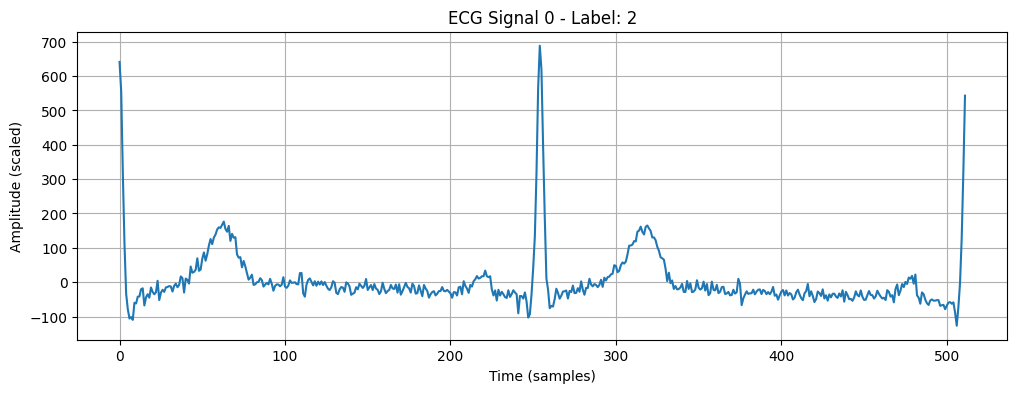

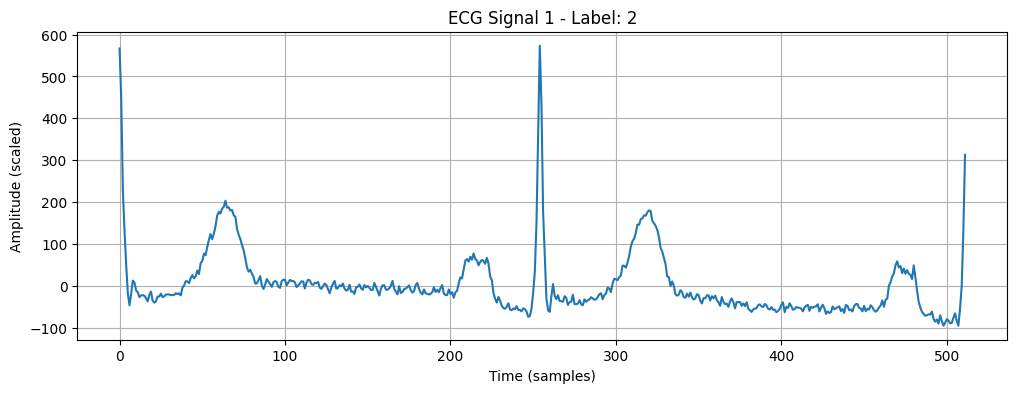

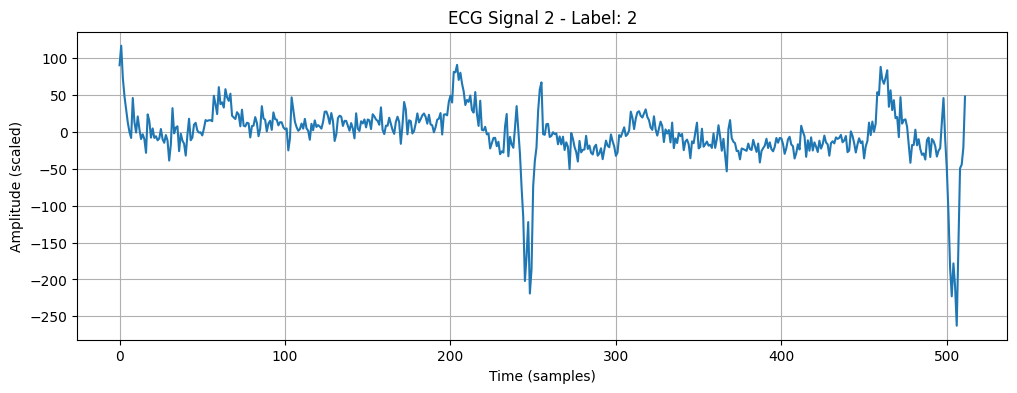

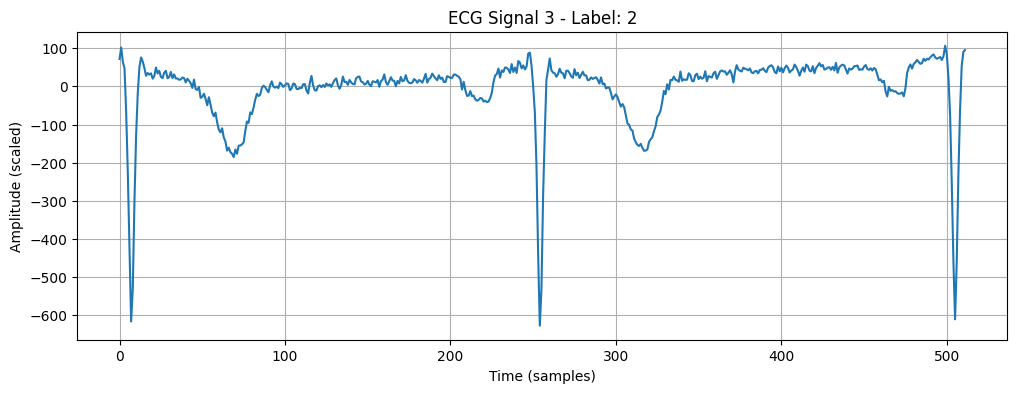

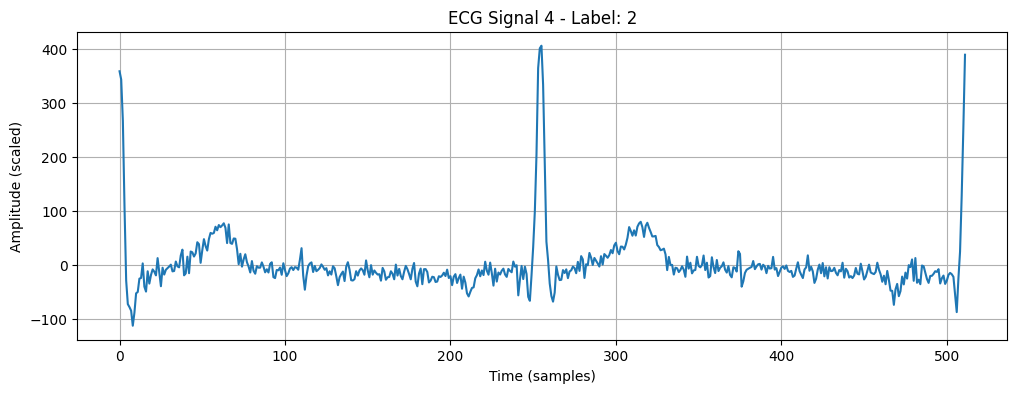

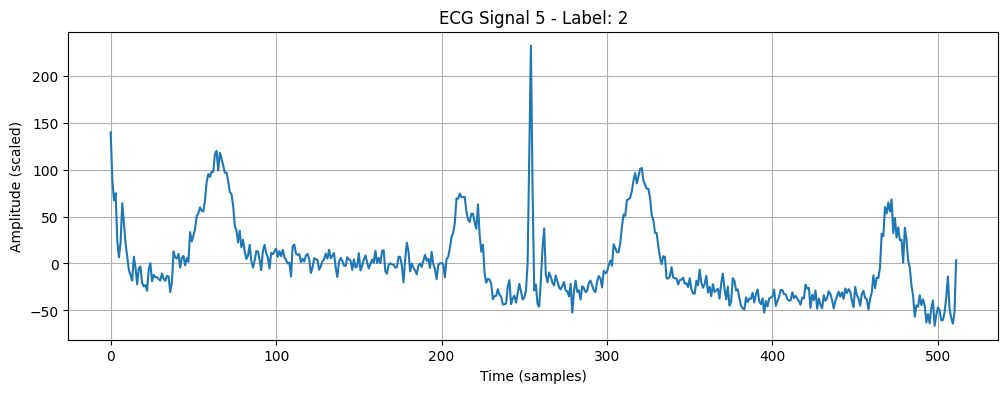

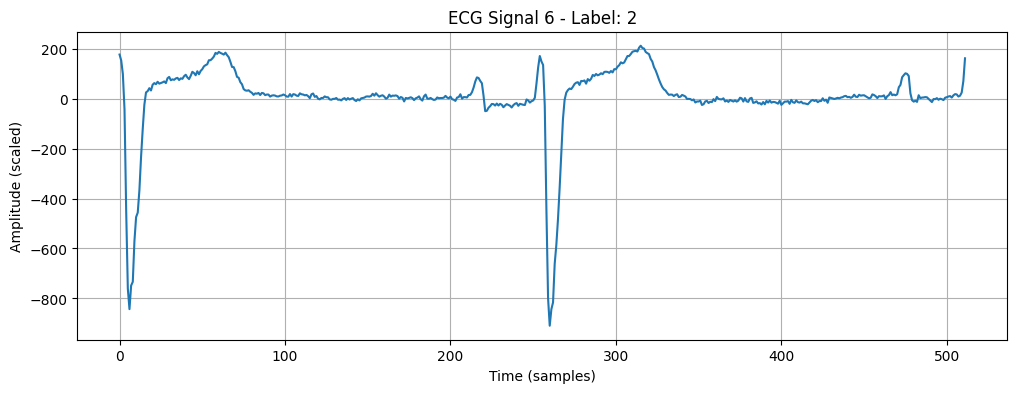

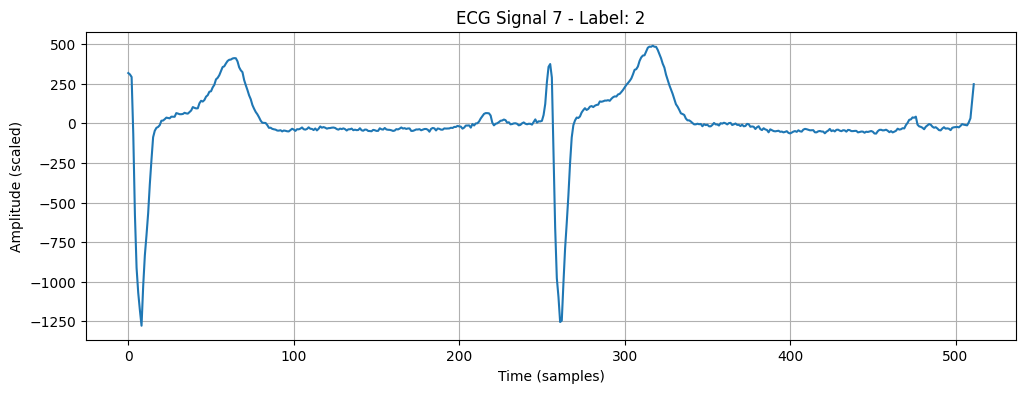

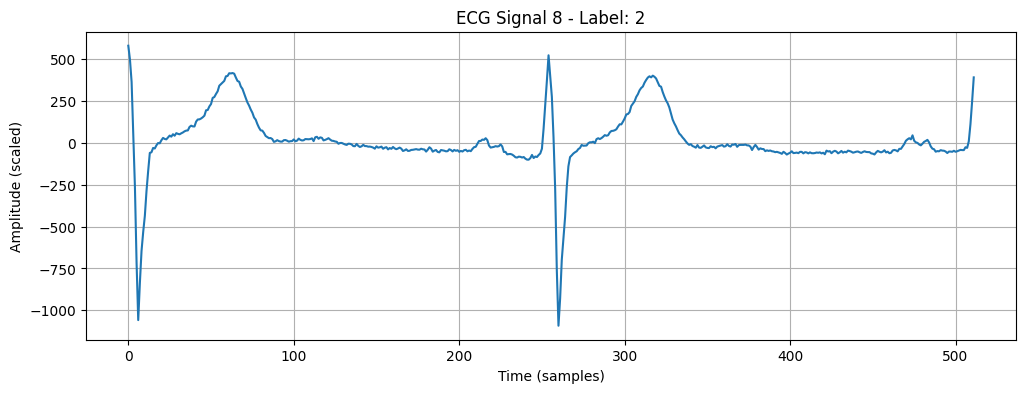

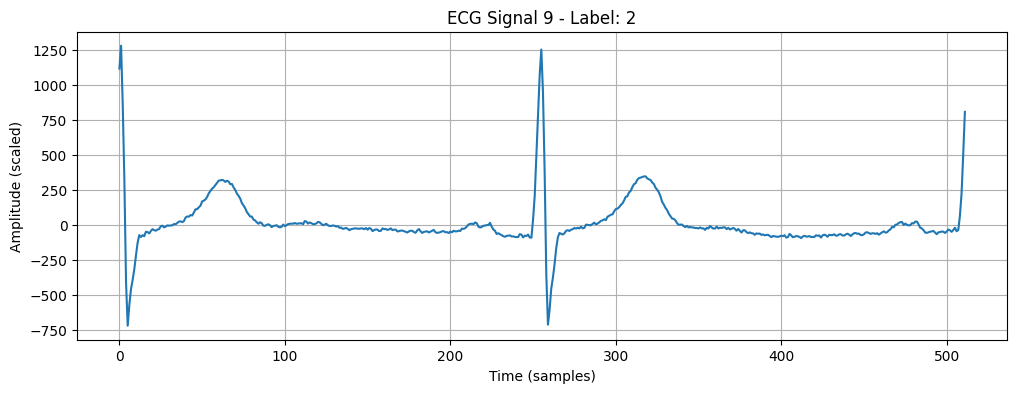

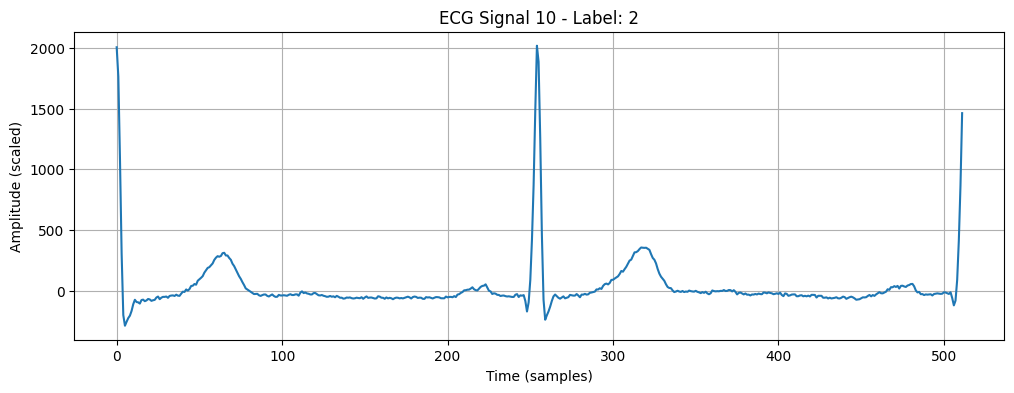

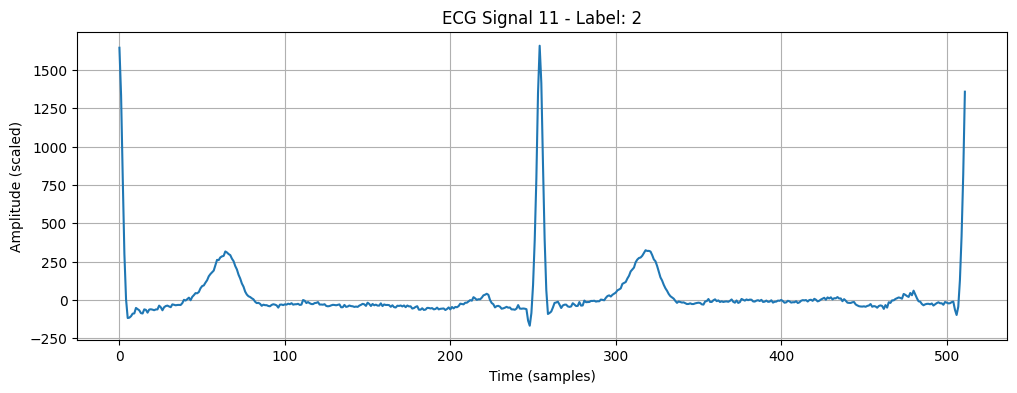

Plotting all 12 leads of 5 ECG signal from the test set:


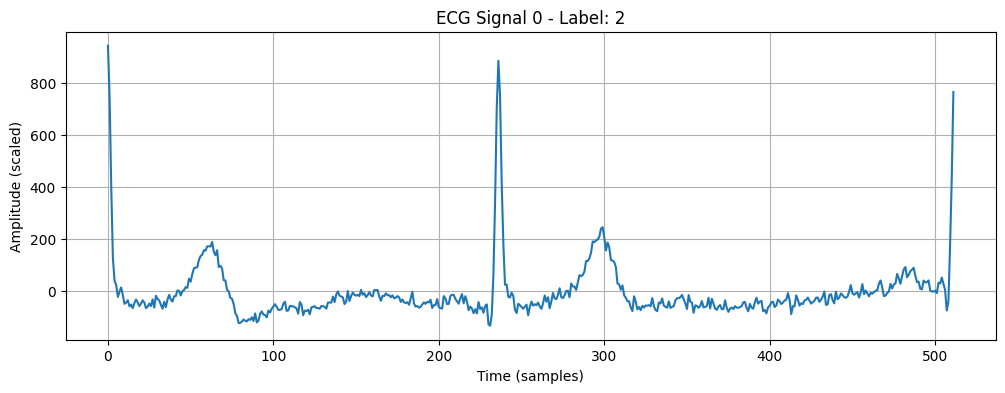

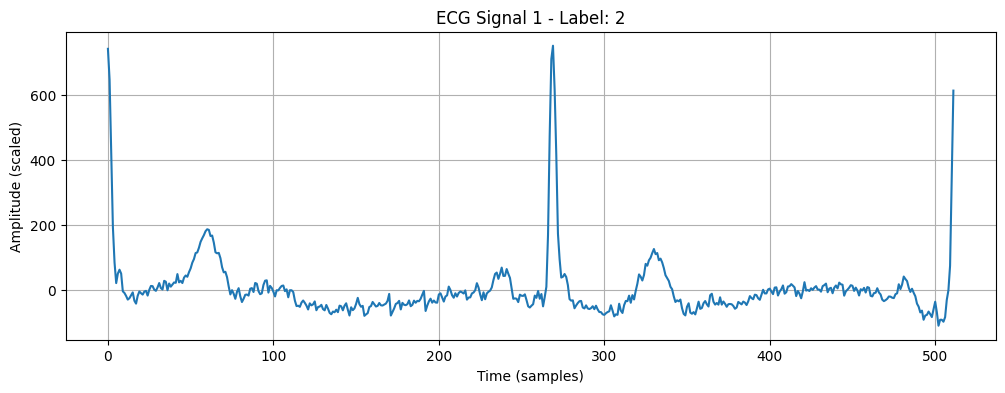

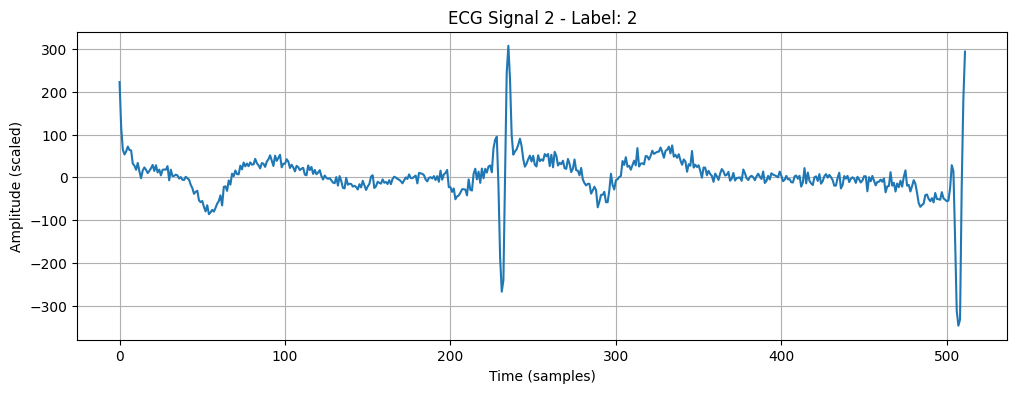

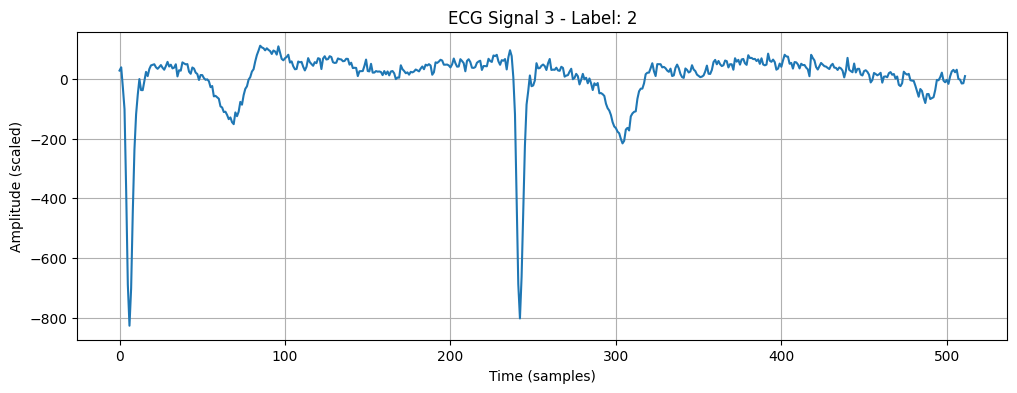

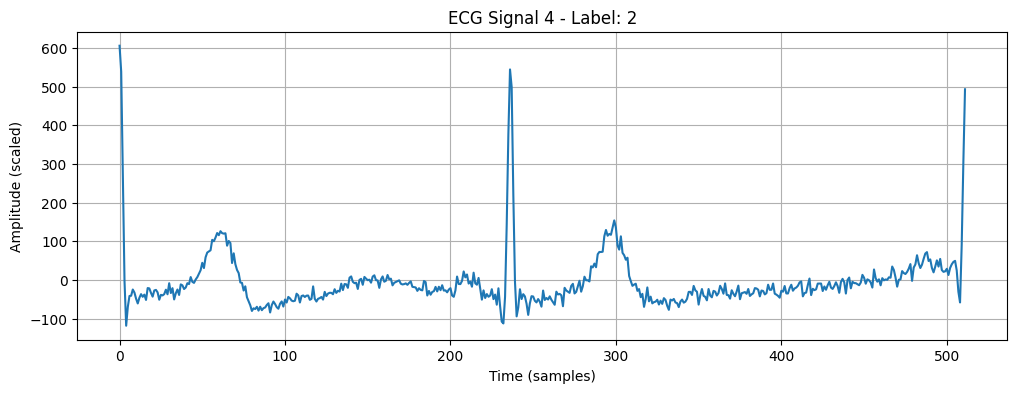

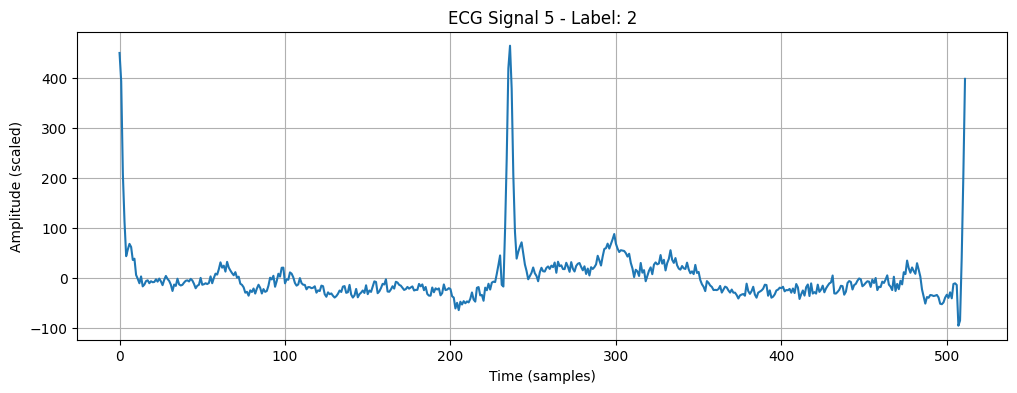

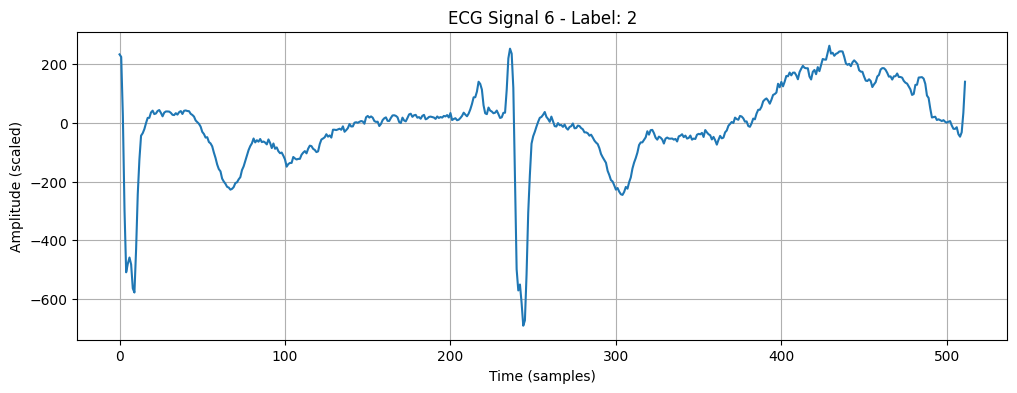

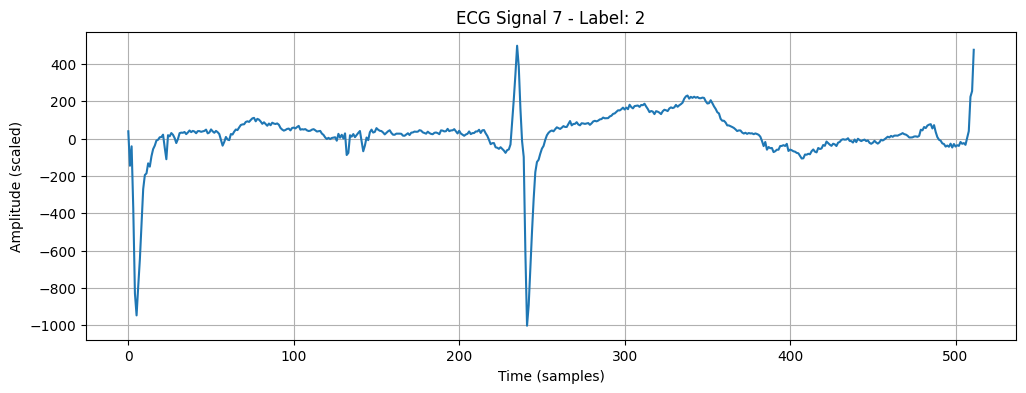

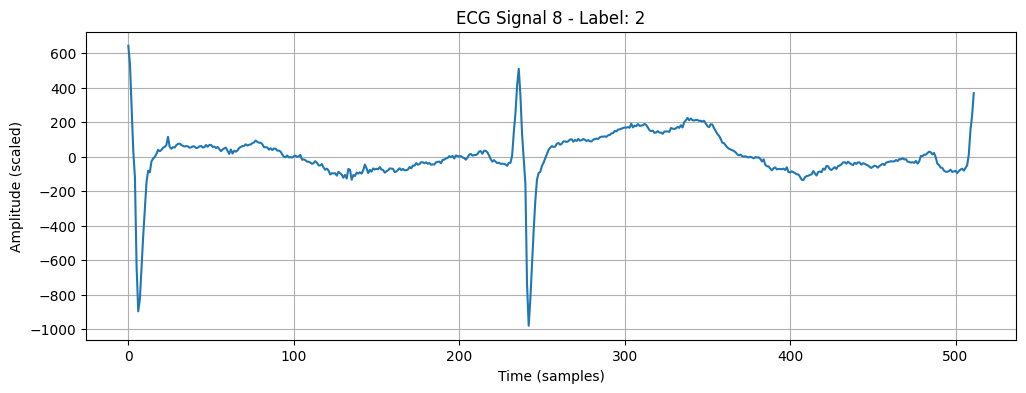

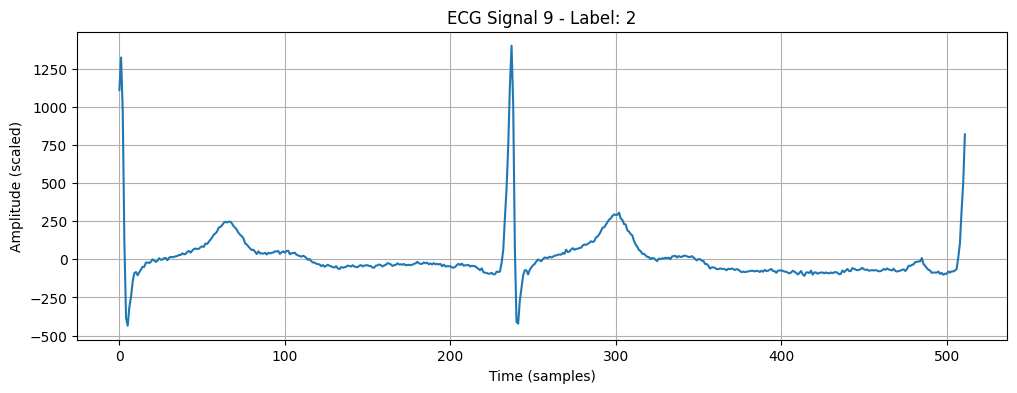

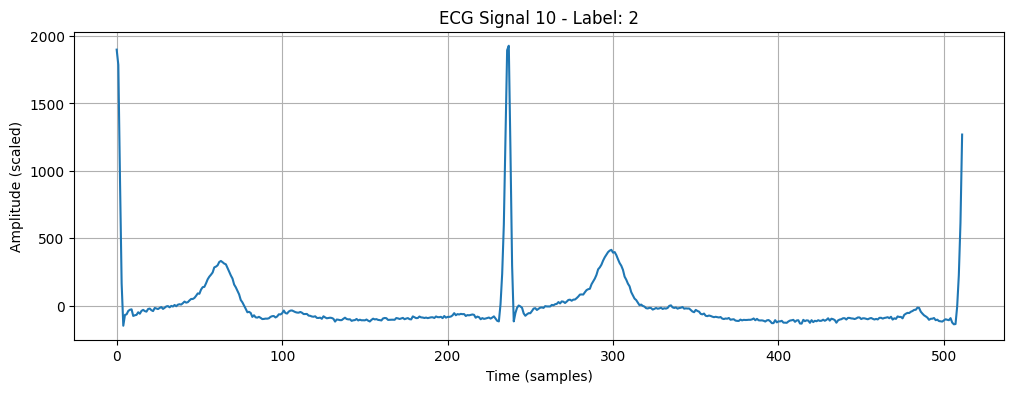

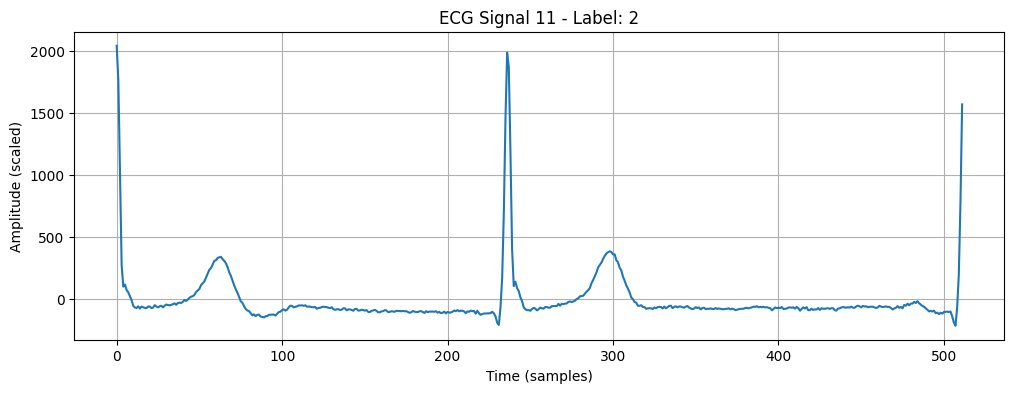

In [80]:
import numpy as np
import matplotlib.pyplot as plt

# Print shapes of the datasets
print("Training data shape:", X_train.shape)
# print("Validation data shape:", X_val_scaled.shape)
print("Test data shape:", X_test.shape)

# Print label distributions
unique, counts = np.unique(y_train, return_counts=True)
print("Training labels distribution:")
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")

unique, counts = np.unique(y_val, return_counts=True)
print("\nValidation labels distribution:")
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")

unique, counts = np.unique(y_test, return_counts=True)
print("\nTest labels distribution:")
for label, count in zip(unique, counts):
    print(f"Label {label}: {count} samples")

# Function to plot an ECG signal
def plot_ecg(signal, label, idx):
    
    plt.figure(figsize=(12, 4))
    plt.plot(signal)
    plt.title(f"ECG Signal {idx} - Label: {label}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude (scaled)")
    plt.grid(True)
    plt.show()

# Plot all 12 leads of first sample from the training data
print("\nPlotting all 12 leads of first ECG signal from the training set:")
for i in range(12):
    signal = X_train[0][i]
    label = y_train[0][0]
    plot_ecg(signal, label, i)

# Plot all 12 leads of first sample from the test data
print("Plotting all 12 leads of 5 ECG signal from the test set:")
for i in range(12):
    signal = X_test[0][i]
    label = y_test[0][0]
    plot_ecg(signal, label, i)


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    """
    A Residual Block as introduced in ResNet.
    """
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride, padding, bias=False)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.elu = nn.ELU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample
        self.se = SELayer(out_channels)  # Squeeze-and-Excitation

    def forward(self, x):
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.elu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.se(out)  # Apply SE block

        if self.downsample:
            identity = self.downsample(x)

        out += identity
        out = self.elu(out)

        return out


class SELayer(nn.Module):
    """
    Squeeze-and-Excitation (SE) block.
    """
    def __init__(self, channel, reduction=16):
        super(SELayer, self).__init__()
        self.fc1 = nn.Linear(channel, channel // reduction, bias=False)
        self.fc2 = nn.Linear(channel // reduction, channel, bias=False)
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # Squeeze
        b, c, _ = x.size()
        y = F.adaptive_avg_pool1d(x, 1).view(b, c)
        # Excitation
        y = self.fc1(y)
        y = F.relu(y, inplace=True)
        y = self.fc2(y)
        y = self.sigmoid(y).view(b, c, 1)
        # Scale
        return x * y.expand_as(x)


class GlobalAttention(nn.Module):
    """
    Global Attention mechanism that takes into account both ECG and duration features.
    """
    def __init__(self, ecg_feature_size, duration_feature_size, intermediate_size=128):
        super(GlobalAttention, self).__init__()
        self.fc1 = nn.Linear(ecg_feature_size + duration_feature_size, intermediate_size, bias=False)
        self.elu = nn.ELU(inplace=True)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(intermediate_size, ecg_feature_size, bias=False)
        self.sigmoid = nn.Sigmoid()

    def forward(self, ecg_features, duration_features):
        """
        Args:
            ecg_features (torch.Tensor): Shape [batch_size, ecg_feature_size]
            duration_features (torch.Tensor): Shape [batch_size, duration_feature_size]
        
        Returns:
            torch.Tensor: Attention weights of shape [batch_size, ecg_feature_size]
        """
        combined = torch.cat((ecg_features, duration_features), dim=-1)  # [batch_size, ecg + duration]
        y = self.fc1(combined)  # [batch_size, intermediate_size]
        y = self.elu(y)
        y = self.dropout(y)
        y = self.fc2(y)  # [batch_size, ecg_feature_size]
        y = self.sigmoid(y)  # [batch_size, ecg_feature_size]
        return y


class AttentionConvFcClassifier(nn.Module):
    def __init__(self, num_classes=3, target_length=32, cycle_num=2):
        """
        Enhanced ConvFcClassifier with Residual Blocks, SE layers, and Global Attention.

        Args:
            num_classes (int): Number of target classes for classification.
            target_length (int): The desired sequence length after adaptive pooling.
            cycle_num (int): Number of ECG cycles per sample.
        """
        super(AttentionConvFcClassifier, self).__init__()
        
        self.cycle_num = cycle_num
        self.cycle_length = 256  # Assuming fixed length of each cycle

        # Initial Convolution for ECG Data
        self.initial_conv = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=8*cycle_num, kernel_size=7, stride=2, padding=3, bias=False),
            nn.BatchNorm1d(8*cycle_num),
            nn.ELU(inplace=True),
            nn.MaxPool1d(kernel_size=3, stride=2, padding=1)
        )
        
        # Residual Layers for ECG Data
        self.layer1 = self._make_layer(8*cycle_num, 16*cycle_num, blocks=2, stride=2)
        self.layer2 = self._make_layer(16*cycle_num, 32*cycle_num, blocks=2, stride=2)
        self.layer3 = self._make_layer(32*cycle_num, 64*cycle_num, blocks=2, stride=2)
        
        # Adaptive Pooling for ECG Data
        self.adaptive_pool = nn.AdaptiveAvgPool1d(target_length)
        
        # Global Context Attention for ECG Data and Duration
        # The attention now takes into account both ECG and duration features
        # ECG features size after adaptive pooling: 64*cycle_num * target_length
        # Duration features size after projection: 64*cycle_num
        self.global_attention = GlobalAttention(
            ecg_feature_size=64*cycle_num * target_length,
            duration_feature_size=64*cycle_num,
            intermediate_size=128*cycle_num
        )
        
        # Projection Layer for Duration Feature
        self.duration_projection = nn.Sequential(
            nn.Linear(1, 64 * cycle_num),
            nn.BatchNorm1d(64 * cycle_num),
            nn.ELU(inplace=True),
            nn.Dropout(0.5)
        )
        
        # Classification Head
        self.classifier = nn.Sequential(
            nn.Linear(64*cycle_num * target_length + 64*cycle_num, 64*cycle_num),
            nn.BatchNorm1d(64*cycle_num),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64*cycle_num, 32*cycle_num),
            nn.BatchNorm1d(32*cycle_num),
            nn.ELU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(32*cycle_num, num_classes)  # Output layer without activation (logits)
        )

    def _make_layer(self, in_channels, out_channels, blocks, stride=1):
        """
        Creates a layer consisting of Residual Blocks.

        Args:
            in_channels (int): Number of input channels.
            out_channels (int): Number of output channels.
            blocks (int): Number of Residual Blocks.
            stride (int): Stride for the first block.

        Returns:
            nn.Sequential: A sequential container of Residual Blocks.
        """
        downsample = None
        if stride != 1 or in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm1d(out_channels)
            )

        layers = []
        layers.append(ResidualBlock(in_channels, out_channels, stride=stride, downsample=downsample))
        for _ in range(1, blocks):
            layers.append(ResidualBlock(out_channels, out_channels))

        return nn.Sequential(*layers)


    def forward(self, x):
        """
        Forward pass of the ConvFcClassifier.

        Args:
            x (torch.Tensor): Input tensor of shape [batch_size, 1, sequence_length]

        Returns:
            torch.Tensor: Logits tensor of shape [batch_size, num_classes]
        """
        # Split the input into ECG cycles and duration
        # Assuming the last dimension is the sequence length, and duration is a separate feature
        # Modify this part based on the actual input format
        # Here, we assume that the duration is the last value in the sequence
        ecg_data = x[:, :, :-1]  # All cycles data
        duration = x[:, :, -1]    # Duration feature, shape: [batch_size, 1]

        # Reshape ECG data to have shape (batch_size, 1, cycles_length * cycle_num)
        ecg_data = ecg_data.view(ecg_data.size(0), 1, -1)

        # Convolutional layers for ECG data
        ecg_features = self.initial_conv(ecg_data)
        ecg_features = self.layer1(ecg_features)
        ecg_features = self.layer2(ecg_features)
        ecg_features = self.layer3(ecg_features)
        ecg_features = self.adaptive_pool(ecg_features)  # Shape: [batch_size, 64*cycle_num, target_length]

        # Flatten the ECG feature map
        ecg_flat = ecg_features.view(ecg_features.size(0), -1)  # Shape: [batch_size, 64*cycle_num * target_length]

        # Project duration feature
        duration_proj = self.duration_projection(duration).squeeze(-1)  # Shape: [batch_size, 64*cycle_num]

        # Compute attention weights using both ECG and duration features
        attention_weights = self.global_attention(ecg_flat, duration_proj)  # Shape: [batch_size, 64*cycle_num * target_length]
        attention_weights = attention_weights.view(ecg_features.size(0), 64*self.cycle_num, -1)  # Shape: [batch_size, 64*cycle_num, target_length]
        ecg_features = ecg_features * attention_weights  # Apply attention

        # Flatten after attention
        ecg_flat = ecg_features.view(ecg_features.size(0), -1)  # Shape: [batch_size, 64*cycle_num * target_length]

        # Concatenate ECG features with projected duration
        combined_features = torch.cat((ecg_flat, duration_proj), dim=-1)  # Shape: [batch_size, 64*cycle_num * target_length + 64*cycle_num]

        # Classification head
        out = self.classifier(combined_features)  # Shape: [batch_size, num_classes]

        return out

In [12]:

# Define model parameters
hidden_dim = cycle_num * 128     # Example hidden dimension for AttentionLSTMClassifier
num_layers = cycle_num * 8       # Number of LSTM layers for AttentionLSTMClassifier
num_classes = len(code_to_label)  # Number of target classes
target_length = cycle_num * 8
num_heads= cycle_num * 8
bidirectional = True               # Enable bidirectional LSTM for better performance


# Initialize Classifier Models
# dense_classifier = DenseClassifier(256*cycle_num, num_classes=num_classes).to(device)
conv_fc_classifier = ConvFcClassifier(num_classes=num_classes, target_length=target_length, cycle_num=cycle_num).to(device)
# attention_lstm_classifier = AttentionLSTMClassifier(
#     hidden_dim=hidden_dim, 
#     num_layers=num_layers, 
#     num_classes=num_classes, 
#     target_length=target_length,
#     bidirectional=bidirectional,
#     num_heads=num_heads,
#     cycle_num=cycle_num
# ).to(device)

In [13]:

# print("Training Dense Classifier...")
# dense_classifier, train_losses_dense, val_losses_dense, val_accuracies_dense = train_classifier(
#     model=dense_classifier, 
#     train_loader=train_loader, 
#     val_loader=val_loader,
#     epochs=500, 
#     patience=50, 
#     lr=0.00005, 
#     device=device
# )

print("Training ConvFc Classifier...")
conv_fc_classifier, train_losses_conv_fc, val_losses_conv_fc, val_accuracies_conv_fc = train_classifier(
    model=conv_fc_classifier, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    epochs=500, 
    patience=100, 
    lr=0.00005, 
    device=device
)


# print("Training AttentionLSTM Classifier...")
# attention_lstm_classifier, train_losses_attention_lstm, val_losses_attention_lstm, val_accuracies_attention_lstm = train_classifier(
#     model=attention_lstm_classifier, 
#     train_loader=train_loader, 
#     val_loader=val_loader, 
#     epochs=500, 
#     patience=50, 
#     lr=0.00005, 
#     device=device
# )






Training ConvFc Classifier...
Epoch 1/500, Train Loss: 1.9196, Val Loss: 1.4968, Val Accuracy: 0.6060
Validation loss decreased, saving the model...
Epoch 2/500, Train Loss: 1.2888, Val Loss: 1.0285, Val Accuracy: 0.7212
Validation loss decreased, saving the model...
Epoch 3/500, Train Loss: 1.1450, Val Loss: 1.0447, Val Accuracy: 0.7086
No improvement in validation loss for 1 epoch(s).
Epoch 4/500, Train Loss: 1.0707, Val Loss: 0.9122, Val Accuracy: 0.7483
Validation loss decreased, saving the model...
Epoch 5/500, Train Loss: 1.0199, Val Loss: 0.8996, Val Accuracy: 0.7444
Validation loss decreased, saving the model...
Epoch 6/500, Train Loss: 0.9816, Val Loss: 0.8868, Val Accuracy: 0.7511
Validation loss decreased, saving the model...
Epoch 7/500, Train Loss: 0.9483, Val Loss: 0.8018, Val Accuracy: 0.7725
Validation loss decreased, saving the model...
Epoch 8/500, Train Loss: 0.9194, Val Loss: 0.7934, Val Accuracy: 0.7748
Validation loss decreased, saving the model...
Epoch 9/500, Tr

In [14]:
def plot_training_history(train_losses, val_losses, val_accuracies, model_name):
    """
    Plots the training and validation loss and validation accuracy.

    Args:
        train_losses (list): List of training losses per epoch.
        val_losses (list): List of validation losses per epoch.
        val_accuracies (list): List of validation accuracies per epoch.
        model_name (str): Name of the model for labeling.
    """
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(14, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'b-', label='Training Loss')
    plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
    plt.title(f'{model_name} - Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, val_accuracies, 'g-', label='Validation Accuracy')
    plt.title(f'{model_name} - Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


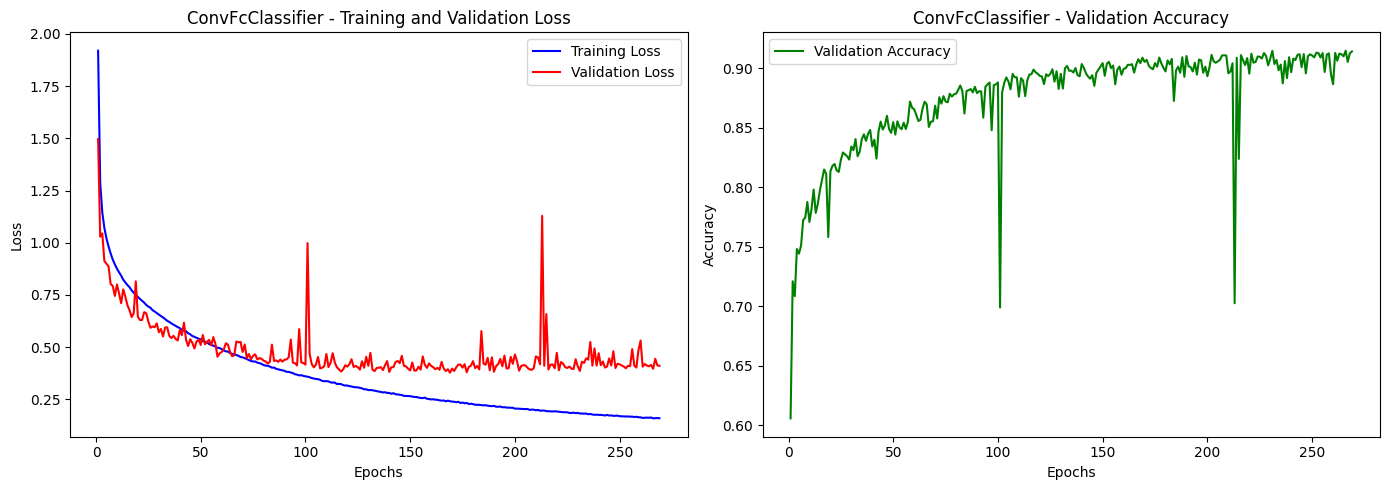

In [15]:
# # Plot for AttentionLSTMClassifier
# plot_training_history(
#     train_losses=train_losses_attention_lstm,
#     val_losses=val_losses_attention_lstm,
#     val_accuracies=val_accuracies_attention_lstm,
#     model_name='AttentionLSTMClassifier'
# )

# # Plot for ConvFcClassifier
plot_training_history(
    train_losses=train_losses_conv_fc,
    val_losses=val_losses_conv_fc,
    val_accuracies=val_accuracies_conv_fc,
    model_name='ConvFcClassifier'
)

# # Plot for DenseClassifier
# plot_training_history(
#     train_losses=train_losses_dense,
#     val_losses=val_losses_dense,
#     val_accuracies=val_accuracies_dense,
#     model_name='DenseClassifier'
# )


In [16]:
# Assuming y_test contains the true labels for the test set
# If y_test is not defined, retrieve it from your test_dataset
# For example:
# y_test = test_dataset.tensors[1].numpy()

# Evaluate AttentionLSTMClassifier
# mean_test_loss_att_lstm, test_accuracy_att_lstm, classification_errors_att_lstm, outputs_att_lstm = evaluate_classifier(
#     model=attention_lstm_classifier,
#     test_loader=test_loader,
#     device=device
# )
# print(f"AttentionLSTMClassifier - Test Loss: {mean_test_loss_att_lstm:.4f}, Test Accuracy: {test_accuracy_att_lstm:.4f}")

# Evaluate ConvFcClassifier
mean_test_loss_conv_fc, test_accuracy_conv_fc, classification_errors_conv_fc, outputs_conv_fc = evaluate_classifier(
    model=conv_fc_classifier,
    test_loader=test_loader,
    device=device
)
print(f"ConvFcClassifier - Test Loss: {mean_test_loss_conv_fc:.4f}, Test Accuracy: {test_accuracy_conv_fc:.4f}")

# Evaluate DenseClassifier
# mean_test_loss_dense, test_accuracy_dense, classification_errors_dense, outputs_dense = evaluate_classifier(
#     model=dense_classifier,
#     test_loader=test_loader,
#     device=device
# )
# print(f"DenseClassifier - Test Loss: {mean_test_loss_dense:.4f}, Test Accuracy: {test_accuracy_dense:.4f}")


ConvFcClassifier - Test Loss: 0.4160, Test Accuracy: 0.9116


In [17]:
# torch.save(attention_lstm_classifier.state_dict(), './models/4AttentionLSTMClassifier.pth')
torch.save(conv_fc_classifier.state_dict(), f'./models/{cycle_num}ConvFcClassifier.pth')
# torch.save(dense_classifier.state_dict(), './models/4DenseClassifier.pth')

In [18]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas to handle CSV writing
import torch

def generate_reports(true_labels, predicted_labels, model_name, report_file):
    """
    Generates and writes classification report to a file and confusion matrix to a CSV file.

    Args:
        true_labels (numpy.ndarray): True labels.
        predicted_labels (numpy.ndarray): Predicted labels predicted by the model.
        model_name (str): Name of the model for labeling.
        report_file (file object): Open file to write the report.
    """
    # Write model name header
    report_file.write(f"\n--- {model_name} ---\n\n")
    
    # Combine true and predicted labels to get all labels present in the data
    unique_labels = np.unique(np.concatenate((true_labels, predicted_labels)))
    labels = sorted(unique_labels)
    
    # Invert code_to_label to get label_to_disease mapping
    label_to_disease = {v: k for k, v in code_to_label.items()}
    
    print("Unique labels in data:", labels)
    print("label_to_disease:", label_to_disease)
    
    # Ensure all labels are in label_to_disease
    missing_labels = [label for label in labels if label not in label_to_disease]
    if missing_labels:
        print("The following labels are missing in label_to_disease:", missing_labels)
        # Handle missing labels by adding them with a default name
        for label in missing_labels:
            label_to_disease[label] = f"Unknown Label {label}"
    
    # Generate target_names for labels present in data
    target_names = [label_to_disease.get(k, f"Label {k}") for k in labels]
    
    # Generate classification report
    report = classification_report(
        true_labels,
        predicted_labels,
        labels=labels,
        target_names=target_names,
        zero_division=0
    )
    report_file.write("Classification Report:\n")
    report_file.write(report + "\n")
    
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
    
    # Write confusion matrix to a CSV file
    csv_file_path = save_path + f"/{model_name}_confusion_matrix.csv"  # Ensure save_path is defined
    # Convert confusion matrix to DataFrame
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    cm_df.to_csv(csv_file_path, encoding='utf-8')
    
    # Optionally, save the confusion matrix as an image
    plt.figure(figsize=(20,18))  # Adjust size to accommodate the number of classes
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.tight_layout()
    plt.savefig(save_path + f"/{model_name}_confusion_matrix.png")
    plt.close()

# Open a text file in write mode
with open(save_path + "/confusion_matrices.txt", "w") as f:
    # Retrieve true labels from test_dataset
    true_labels = test_dataset.tensors[1].numpy()
    
    # ConvFcClassifier Reports
    predicted_labels_conv_fc = torch.argmax(outputs_conv_fc, dim=1).cpu().numpy()
    generate_reports(true_labels, predicted_labels_conv_fc, "ConvFcClassifier", f)
    
    # If you have other classifiers, you can generate their reports similarly
    # Example for AttentionLSTMClassifier
    # predicted_labels_att_lstm = torch.argmax(outputs_att_lstm, dim=1).cpu().numpy()
    # generate_reports(true_labels, predicted_labels_att_lstm, "AttentionLSTMClassifier", f)


Unique labels in data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
label_to_disease: {0: '10370003', 1: '106068003', 2: '111288001', 3: '11157007', 4: '111975006', 5: '164861001', 6: '164865005', 7: '164884008', 8: '164890007', 9: '164895002', 10: '164896001', 11: '164931005', 12: '17338001', 13: '17366009', 14: '195042002', 15: '195060002', 16: '195080001', 17: '233897008', 18: '233917008', 19: '251166008', 20: '251266004', 21: '251268003', 22: '270492004', 23: '27885002', 24: '284470004', 25: '29320008', 26: '413444003', 27: '425856008', 28: '426177001', 29: '426627000', 30: '426648003', 31: '426664006', 32: '426761007', 33: '427084000', 34: '427172004', 35: '427393009', 36: '429622005', 37: '55930002', 38: '61277005', 39: '63593006', 40: '65778007', 41: '67198005', 42: '698247007', 43: '713422000', 44: '74390002', 45: '75532003', 46: '81898007'}


In [19]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd  # Import pandas to handle CSV writing
import torch
import numpy as np
import os

def generate_reports(true_labels, predicted_labels, model_name, report_file, save_path):
    """
    Generates and writes classification report to a file, confusion matrix to a CSV file,
    and analyzes misclassifications for potential disease groupings.

    Args:
        true_labels (numpy.ndarray): True labels.
        predicted_labels (numpy.ndarray): Predicted labels predicted by the model.
        model_name (str): Name of the model for labeling.
        report_file (file object): Open file to write the report.
        save_path (str): Directory path to save CSV and image files.
    """
    # Write model name header
    report_file.write(f"\n--- {model_name} ---\n\n")
    
    # Combine true and predicted labels to get all labels present in the data
    unique_labels = np.unique(np.concatenate((true_labels, predicted_labels)))
    labels = sorted(unique_labels)
    
    # Invert code_to_label to get label_to_disease mapping
    label_to_disease = {v: k for k, v in code_to_label.items()}
    
    print("Unique labels in data:", labels)
    print("label_to_disease:", label_to_disease)
    
    # Ensure all labels are in label_to_disease
    missing_labels = [label for label in labels if label not in label_to_disease]
    if missing_labels:
        print("The following labels are missing in label_to_disease:", missing_labels)
        # Handle missing labels by adding them with a default name
        for label in missing_labels:
            label_to_disease[label] = f"Unknown Label {label}"
    
    # Generate target_names for labels present in data
    target_names = [label_to_disease.get(k, f"Label {k}") for k in labels]
    
    # Generate classification report
    report = classification_report(
        true_labels,
        predicted_labels,
        labels=labels,
        target_names=target_names,
        zero_division=0
    )
    report_file.write("Classification Report:\n")
    report_file.write(report + "\n")
    
    # Generate confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels, labels=labels)
    
    # Write confusion matrix to a CSV file
    csv_file_path = os.path.join(save_path, f"{model_name}_confusion_matrix.csv")
    cm_df = pd.DataFrame(cm, index=target_names, columns=target_names)
    cm_df.to_csv(csv_file_path, encoding='utf-8')
    print(f"Confusion matrix CSV saved at: {csv_file_path}")
    
    # Optionally, save the confusion matrix as an image
    plt.figure(figsize=(20,18))  # Adjust size to accommodate the number of classes
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.tight_layout()
    image_file_path = os.path.join(save_path, f"{model_name}_confusion_matrix.png")
    plt.savefig(image_file_path)
    plt.close()
    print(f"Confusion matrix image saved at: {image_file_path}")
    
    # **Misclassification Analysis**
    
    # Remove the diagonal to focus on misclassifications
    cm_no_diag = cm_df.copy()
    np.fill_diagonal(cm_no_diag.values, 0)
    
    # Melt the DataFrame to have a long-form table
    confusion_melted = cm_no_diag.reset_index().melt(id_vars='index', var_name='Predicted', value_name='Count')
    confusion_melted = confusion_melted.rename(columns={'index': 'Actual'})
    
    # Sort by Count descending to identify top misclassifications
    top_misclassifications = confusion_melted.sort_values(by='Count', ascending=False)
    
    # Display top 10 misclassifications
    top_10_misclass = top_misclassifications.head(10)
    print("\nTop 10 Misclassifications:")
    print(top_10_misclass)
    
    # Write top misclassifications to the report
    report_file.write("\nTop 10 Misclassifications Overall:\n")
    report_file.write(top_10_misclass.to_string(index=False))
    
    # For each actual disease, find the predicted disease with the highest misclassification
    top_misclass_per_disease = cm_no_diag.idxmax(axis=1)
    top_counts = cm_no_diag.max(axis=1)
    
    top_misclass_per_disease_df = pd.DataFrame({
        'Actual Disease': cm_no_diag.index,
        'Most Misclassified As': top_misclass_per_disease.values,
        'Count': top_counts.values
    })
    
    print("\nTop Misclassifications Per Disease:")
    print(top_misclass_per_disease_df)
    
    # Write top misclassifications per disease to the report
    report_file.write("\n\nTop Misclassifications Per Disease:\n")
    report_file.write(top_misclass_per_disease_df.to_string(index=False))
    
    # Find mutual confusions: A -> B and B -> A
    mutual_confusions = []
    for actual in cm_no_diag.index:
        predicted = cm_no_diag.loc[actual].idxmax()
        if actual != predicted:
            predicted_top = cm_no_diag.loc[predicted].idxmax()
            if predicted_top == actual:
                pair = tuple(sorted([actual, predicted]))
                if pair not in mutual_confusions:
                    mutual_confusions.append(pair)
    
    print("\nMutual Confusions (Pairs of Diseases):")
    for pair in mutual_confusions:
        print(f"{pair[0]} <--> {pair[1]}")
    
    # Write mutual confusions to the report
    report_file.write("\n\nMutual Confusions (Pairs of Diseases):\n")
    if mutual_confusions:
        for pair in mutual_confusions:
            report_file.write(f"{pair[0]} <--> {pair[1]}\n")
    else:
        report_file.write("No mutual confusions detected.\n")


In [20]:
import torch  # Ensure torch is imported if not already

# Open a text file in write mode for the classification report
report_txt_path = os.path.join(save_path, "confusion_matrices.txt")
with open(report_txt_path, "w") as f:
    # Retrieve true labels from test_dataset
    true_labels = test_dataset.tensors[1].numpy()
    
    # ConvFcClassifier Reports
    predicted_labels_conv_fc = torch.argmax(outputs_conv_fc, dim=1).cpu().numpy()
    generate_reports(true_labels, predicted_labels_conv_fc, "ConvFcClassifier", f, save_path)
    
    # If you have other classifiers, generate their reports similarly
    # Example for AttentionLSTMClassifier
    # predicted_labels_att_lstm = torch.argmax(outputs_att_lstm, dim=1).cpu().numpy()
    # generate_reports(true_labels, predicted_labels_att_lstm, "AttentionLSTMClassifier", f, save_path)
    
    # Example for DenseClassifier
    # predicted_labels_dense = torch.argmax(outputs_dense, dim=1).cpu().numpy()
    # generate_reports(true_labels, predicted_labels_dense, "DenseClassifier", f, save_path)


Unique labels in data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46]
label_to_disease: {0: '10370003', 1: '106068003', 2: '111288001', 3: '11157007', 4: '111975006', 5: '164861001', 6: '164865005', 7: '164884008', 8: '164890007', 9: '164895002', 10: '164896001', 11: '164931005', 12: '17338001', 13: '17366009', 14: '195042002', 15: '195060002', 16: '195080001', 17: '233897008', 18: '233917008', 19: '251166008', 20: '251266004', 21: '251268003', 22: '270492004', 23: '27885002', 24: '284470004', 25: '29320008', 26: '413444003', 27: '425856008', 28: '426177001', 29: '426627000', 30: '426648003', 31: '426664006', 32: '426761007', 33: '427084000', 34: '427172004', 35: '427393009', 36: '429622005', 37: '55930002', 38: '61277005', 39: '63593006', 40: '65778007', 41: '67198005', 42: '698247007', 43: '713422000', 44: '74390002', 45: '75532003', 46: '81898007'}
Conf

In [21]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# import os
# import seaborn as sns
# import matplotlib.pyplot as plt

# # Define the save_path where your CSV and outputs are stored
# save_path = r"C:\ecg_project\main_system\disease_classification\outputs\20240928162545_cycle_3all"  # Replace with your actual save path

# # Define the path to your confusion matrix CSV
# file_path = os.path.join(save_path, "ConvFcClassifier_confusion_matrix.csv")  # Ensure the file exists here

# # Load the confusion matrix into a pandas DataFrame with all labels as strings
# try:
#     cm_df = pd.read_csv(file_path, index_col=0, dtype=str)  # Read all labels as strings
# except FileNotFoundError:
#     print(f"Error: The file at {file_path} was not found.")
#     exit()
# except pd.errors.EmptyDataError:
#     print("Error: The provided CSV file is empty.")
#     exit()
# except Exception as e:
#     print(f"An unexpected error occurred while reading the CSV: {e}")
#     exit()

# print("Original Confusion Matrix:")
# print(cm_df)



In [22]:

# # Ensure that all index and column labels are stripped of leading/trailing whitespace
# cm_df.index = cm_df.index.astype(str).str.strip()
# cm_df.columns = cm_df.columns.str.strip()

# # Verify the data types
# print("\nData Types After Conversion:")
# print(f"Index Type: {cm_df.index.dtype}")
# print(f"Columns Type: {cm_df.columns.dtype}")

# # Define the classes to merge and assign new group names
# merge_mapping = {
#     'Merged_Group1': ['164889003', '164890007'],
#     'Merged_Group2': ['425856008', '426761007'],
#     'Merged_Group3': ['426177001', '426783006']
# }

# # List of all classes (as strings)
# all_classes = cm_df.index.tolist()

# # Step 1: Create a mapping from original classes to merged groups
# class_to_group = {}
# for group, classes in merge_mapping.items():
#     for cls in classes:
#         class_to_group[cls] = group

# # Assign remaining classes to themselves
# for cls in all_classes:
#     if cls not in class_to_group:
#         class_to_group[cls] = cls

# # Debug: Print the class_to_group mapping to verify
# print("\nClass to Group Mapping:")
# for cls, group in class_to_group.items():
#     print(f"{cls} --> {group}")

# # Step 2: Create a list of unique groups
# unique_groups = sorted(list(set(class_to_group.values())))

# # Initialize a new confusion matrix DataFrame with merged groups
# merged_cm_df = pd.DataFrame(0, index=unique_groups, columns=unique_groups)

# # Populate the merged confusion matrix
# for actual_class in cm_df.index:
#     actual_group = class_to_group.get(actual_class, 'Unknown Group')  # Safely get the group
#     for predicted_class in cm_df.columns:
#         predicted_group = class_to_group.get(predicted_class, 'Unknown Group')  # Safely get the group
#         count = cm_df.at[actual_class, predicted_class]
#         try:
#             count = int(count)
#         except ValueError:
#             print(f"Warning: Non-integer value '{count}' found for Actual: {actual_class}, Predicted: {predicted_class}. Setting count to 0.")
#             count = 0
#         merged_cm_df.at[actual_group, predicted_group] += count

# print("\nMerged Confusion Matrix:")
# print(merged_cm_df)

# # Flatten the confusion matrix to obtain true and predicted labels
# true_labels_list = []
# predicted_labels_list = []

# for actual_group in merged_cm_df.index:
#     for predicted_group in merged_cm_df.columns:
#         count = merged_cm_df.at[actual_group, predicted_group]
#         if count > 0:
#             true_labels_list.extend([actual_group] * count)
#             predicted_labels_list.extend([predicted_group] * count)

# # Convert lists to numpy arrays
# true_labels_array = np.array(true_labels_list)
# predicted_labels_array = np.array(predicted_labels_list)

# # Calculate accuracy
# accuracy = accuracy_score(true_labels_array, predicted_labels_array)
# print(f"\nAccuracy After Merging: {accuracy:.4f}")

In [23]:

# # Ensure that all index and column labels are stripped of leading/trailing whitespace
# cm_df.index = cm_df.index.astype(str).str.strip()
# cm_df.columns = cm_df.columns.str.strip()

# # Verify the data types
# print("\nData Types After Conversion:")
# print(f"Index Type: {cm_df.index.dtype}")
# print(f"Columns Type: {cm_df.columns.dtype}")

# # Define the classes to merge and assign new group names
# merge_mapping = {
#     'Merged_Group1': ['164889003', '164890007'],
#     'Merged_Group2': ['425856008', '426761007'],
#     'Merged_Group3': ['426177001', '426783006']
# }

# # List of all classes (as strings)
# all_classes = cm_df.index.tolist()

# # Step 1: Create a mapping from original classes to merged groups
# class_to_group = {}
# for group, classes in merge_mapping.items():
#     for cls in classes:
#         class_to_group[cls] = group

# # Assign remaining classes to themselves
# for cls in all_classes:
#     if cls not in class_to_group:
#         class_to_group[cls] = cls

# # Debug: Print the class_to_group mapping to verify
# print("\nClass to Group Mapping:")
# for cls, group in class_to_group.items():
#     print(f"{cls} --> {group}")

# # Step 2: Create a list of unique groups
# unique_groups = sorted(list(set(class_to_group.values())))

# # Initialize a new confusion matrix DataFrame with merged groups
# merged_cm_df = pd.DataFrame(0, index=unique_groups, columns=unique_groups)

# # Populate the merged confusion matrix
# for actual_class in cm_df.index:
#     actual_group = class_to_group.get(actual_class, 'Unknown Group')  # Safely get the group
#     for predicted_class in cm_df.columns:
#         predicted_group = class_to_group.get(predicted_class, 'Unknown Group')  # Safely get the group
#         count = cm_df.at[actual_class, predicted_class]
#         try:
#             count = int(count)
#         except ValueError:
#             print(f"Warning: Non-integer value '{count}' found for Actual: {actual_class}, Predicted: {predicted_class}. Setting count to 0.")
#             count = 0
#         merged_cm_df.at[actual_group, predicted_group] += count

# print("\nMerged Confusion Matrix:")
# print(merged_cm_df)

# # Flatten the confusion matrix to obtain true and predicted labels
# true_labels_list = []
# predicted_labels_list = []

# for actual_group in merged_cm_df.index:
#     for predicted_group in merged_cm_df.columns:
#         count = merged_cm_df.at[actual_group, predicted_group]
#         if count > 0:
#             true_labels_list.extend([actual_group] * count)
#             predicted_labels_list.extend([predicted_group] * count)

# # Convert lists to numpy arrays
# true_labels_array = np.array(true_labels_list)
# predicted_labels_array = np.array(predicted_labels_list)

# # Calculate accuracy
# accuracy = accuracy_score(true_labels_array, predicted_labels_array)
# print(f"\nAccuracy After Merging: {accuracy:.4f}")

In [24]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# # Assuming 'merged_cm_df' is your merged confusion matrix DataFrame
# # and 'unique_groups' is a list of group labels

# # Flatten the confusion matrix to obtain true and predicted labels
# true_labels_list = []
# predicted_labels_list = []

# for actual_group in merged_cm_df.index:
#     for predicted_group in merged_cm_df.columns:
#         count = merged_cm_df.at[actual_group, predicted_group]
#         if count > 0:
#             true_labels_list.extend([actual_group] * count)
#             predicted_labels_list.extend([predicted_group] * count)

# # Convert lists to numpy arrays
# true_labels_array = np.array(true_labels_list)
# predicted_labels_array = np.array(predicted_labels_list)

# # Calculate accuracy
# accuracy = accuracy_score(true_labels_array, predicted_labels_array)
# print(f"\nAccuracy After Merging: {accuracy:.4f}")

# # Calculate precision, recall, f1-score for each group
# precision, recall, f1, support = precision_recall_fscore_support(
#     true_labels_array,
#     predicted_labels_array,
#     labels=unique_groups,
#     zero_division=0
# )

# # Create a DataFrame for the metrics
# metrics_df = pd.DataFrame({
#     'Group': unique_groups,
#     'Precision': precision,
#     'Recall': recall,
#     'F1-Score': f1,
#     'Support': support
# })

# # Calculate macro and weighted averages
# macro_precision = np.mean(precision)
# macro_recall = np.mean(recall)
# macro_f1 = np.mean(f1)

# weighted_precision = np.average(precision, weights=support)
# weighted_recall = np.average(recall, weights=support)
# weighted_f1 = np.average(f1, weights=support)

# # Create a DataFrame for the averages
# averages = pd.DataFrame({
#     'Group': ['Macro Average', 'Weighted Average'],
#     'Precision': [macro_precision, weighted_precision],
#     'Recall': [macro_recall, weighted_recall],
#     'F1-Score': [macro_f1, weighted_f1],
#     'Support': [merged_cm_df.values.sum(), merged_cm_df.values.sum()]
# })

# # Concatenate the averages to metrics_df
# metrics_df = pd.concat([metrics_df, averages], ignore_index=True)

# print("\nPerformance Metrics After Merging:")
# print(metrics_df)


In [25]:

# print("\nPerformance Metrics After Merging:")
# print(metrics_df)

# # Save the merged confusion matrix as CSV
# merged_cm_csv_path = os.path.join(save_path, "merged_confusion_matrix.csv")
# merged_cm_df.to_csv(merged_cm_csv_path)
# print(f"\nMerged Confusion Matrix saved at: {merged_cm_csv_path}")

# # Save the performance metrics as CSV
# metrics_csv_path = os.path.join(save_path, "performance_metrics_after_merging.csv")
# metrics_df.to_csv(metrics_csv_path, index=False)
# print(f"Performance Metrics saved at: {metrics_csv_path}")

# # Optional: Save the merged confusion matrix as an image
# plt.figure(figsize=(20,18))  # Adjust size as needed
# sns.heatmap(merged_cm_df, annot=True, fmt='d', cmap='Blues', linewidths=.5)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Merged Confusion Matrix')
# plt.tight_layout()
# image_file_path = os.path.join(save_path, "merged_confusion_matrix.png")
# plt.savefig(image_file_path)
# plt.close()
# print(f"Merged Confusion Matrix image saved at: {image_file_path}")

# # Optional: Normalize and save the normalized confusion matrix
# normalized_cm_df = merged_cm_df.div(merged_cm_df.sum(axis=1), axis=0).fillna(0)

# print("\nNormalized Merged Confusion Matrix:")
# print(normalized_cm_df)

# # Save the normalized confusion matrix as CSV
# normalized_cm_csv_path = os.path.join(save_path, "merged_confusion_matrix_normalized.csv")
# normalized_cm_df.to_csv(normalized_cm_csv_path)
# print(f"\nNormalized Confusion Matrix saved at: {normalized_cm_csv_path}")

# # Plot the normalized confusion matrix
# plt.figure(figsize=(20,18))
# sns.heatmap(normalized_cm_df, annot=True, fmt=".2f", cmap='Blues', linewidths=.5)
# plt.ylabel('Actual')
# plt.xlabel('Predicted')
# plt.title('Normalized Merged Confusion Matrix')
# plt.tight_layout()
# normalized_image_file_path = os.path.join(save_path, "merged_confusion_matrix_normalized.png")
# plt.savefig(normalized_image_file_path)
# plt.close()
# print(f"Normalized Confusion Matrix image saved at: {normalized_image_file_path}")

# # Analyze misclassifications
# # Remove the diagonal to focus on misclassifications
# cm_no_diag = merged_cm_df.copy()
# np.fill_diagonal(cm_no_diag.values, 0)

# # Melt the DataFrame to have a long-form table
# confusion_melted = cm_no_diag.reset_index().melt(id_vars='index', var_name='Predicted', value_name='Count')
# confusion_melted = confusion_melted.rename(columns={'index': 'Actual'})

# # Sort by Count descending to identify top misclassifications
# top_misclassifications = confusion_melted.sort_values(by='Count', ascending=False)

# # Display top 10 misclassifications
# print("\nTop 10 Misclassifications:")
# print(top_misclassifications.head(10))

# # Save the top misclassifications to the report
# report_file_path = os.path.join(save_path, "confusion_matrices.txt")
# with open(report_file_path, "a") as f:
#     f.write("\nTop 10 Misclassifications After Merging:\n")
#     f.write(top_misclassifications.head(10).to_string(index=False))

# # Detect mutual confusions: A -> B and B -> A
# mutual_confusions = []
# for actual in merged_cm_df.index:
#     predicted = merged_cm_df.loc[actual].idxmax()
#     if actual != predicted:
#         predicted_top = merged_cm_df.loc[predicted].idxmax()
#         if predicted_top == actual:
#             pair = tuple(sorted([actual, predicted]))
#             if pair not in mutual_confusions:
#                 mutual_confusions.append(pair)

# print("\nMutual Confusions (Pairs of Diseases):")
# for pair in mutual_confusions:
#     print(f"{pair[0]} <--> {pair[1]}")

# # Save mutual confusions to the report
# with open(report_file_path, "a") as f:
#     f.write("\nMutual Confusions (Pairs of Diseases):\n")
#     if mutual_confusions:
#         for pair in mutual_confusions:
#             f.write(f"{pair[0]} <--> {pair[1]}\n")
#     else:
#         f.write("No mutual confusions detected.\n")
